Comparision of The growth of individual models vs communiyt models

Generate growth of individual models and then generate community solution to establish comparibility.

In [12]:
import micom as mc
import numpy as np
import matplotlib as mp 
import matplotlib.pyplot as plt

from utils import *
from utilPlots import *

In [13]:
# Load pre-built model (Should be quicker)

import cobra.io

models = []
model_paths = ["../../data/GD.xml", "../../data/AG.xml"]

for i in range(len(model_paths)):
    models.append(cobra.io.read_sbml_model(model_paths[i]))

# Vars for Convienince
GD = models[0]
AG = models[1]

com = mc.load_pickle("../../data/community.pickle")
# View dataframe used to build the communty with the taxonomy attribute.
# Note that the abundance column has been populated with default values.
com.taxonomy


Read LP format model from file C:\Users\domin\AppData\Local\Temp\tmp9q5auhdr.lp
Reading time = 0.07 seconds
: 4042 rows, 11287 columns, 43241 nonzeros


,id,genus,species,file,abundance
id,,,,,
AG_uc,AG_uc,ecoli,Ecoli AG,project/data/AG.xml,0.5
GD_uc,GD_uc,ecoli,Ecoli GD,project/data/GD.xml,0.5


In [14]:
sols = {}
sols["AG"] = AG.optimize()
sols["GD"] = GD.optimize()

In [15]:
sols["AG"]

,fluxes,reduced_costs
EX_cm_e,0.000000,0.000000e+00
EX_cmp_e,0.000000,-2.999644e-01
EX_co2_e,17.777514,0.000000e+00
EX_cobalt2_e,-0.000020,-0.000000e+00
DM_4crsol_c,0.000182,0.000000e+00
...,...,...
RNTR3c2,0.022106,-1.040834e-17
KDC4,0.000000,-3.349968e-01
HPAA_ADH,0.000000,-5.204170e-18
Tyrosolex,0.000000,0.000000e+00


In [16]:
sols["GD"]

,fluxes,reduced_costs
ALATA_D2,0.000000,-2.390169e-02
SHCHD2,0.000185,0.000000e+00
CPPPGO,0.000185,0.000000e+00
GTHOr,0.000000,1.110223e-16
DHORD5,0.000000,-2.081668e-17
...,...,...
BIOMASS_Ec_iHK1487_core,0.829430,7.424616e-16
Tyrosolex,0.000000,-7.066588e-02
EX_Tyrosol_e,0.000000,0.000000e+00
SALIDROSIDE_BIOSYNTHESIS,0.000000,0.000000e+00


In [17]:
sols["com_0.5"] = com.cooperative_tradeoff(fraction=0.5,fluxes=True, pfba=True)

In [18]:
sols["com_0.5"]

,abundance,growth_rate,reactions,metabolites
compartments,,,,
AG_uc,0.5,0.908383,2587,1808
GD_uc,0.5,0.914114,2705,1880
medium,NaN,NaN,351,351


What's the best way of approching the comparison? 

Are the predicted community growth rates scaled by abundance? - yes for the community objective..
We can constrain the uptake fluxes for the individual models to that observed for the community solution and compare the resulting value of the objective solution. 

In [19]:

agExch = [i.id for i in AG.exchanges]
# grab those reaction fluxes from the community solution
x = sols["com_0.5"].fluxes.T
x = x[x.index.isin(agExch)].sort_values(by=['AG_uc'], ascending = True)
x.AG_uc

reaction
EX_o2_e       -17.116641
EX_nh4_e      -10.063558
EX_dha_e       -6.921983
EX_xyl__D_e    -6.623890
EX_pi_e        -0.876254
                 ...    
EX_tyr__L_e     0.126257
EX_asn__L_e     0.220352
EX_h_e          8.598707
EX_co2_e       18.027518
EX_h2o_e       42.585043
Name: AG_uc, Length: 325, dtype: float64

In [20]:
# set AG exchanges:
res = ''
with AG as m:
    for rxn in m.exchanges:
        done = False
        for j in range(len(x.AG_uc)):
            newbound = x.AG_uc[j]
            if x.index[j] == rxn.id:
                # print(f"setting {x.index[j]} to {newbound}")
                rxn.bounds = (newbound, newbound)
                done = True
        if not done: 
            print(f"Unable to set {rxn.id}")
    res = m.slim_optimize()
    print("resultant objective function value: " , res)



resultant objective function value:  0.9083828680884029


At a surface level, the objective functions between individual and community appear to be directly comparible.
When the uptake fluxes computed for the consituents were applied to the individual models, effectivly modifying the culture representation, the resulting optimal solutions had the same value as that indicated for in the community model. 

From this we can observe that, when the cooperative tradeoff parameter is set to '0.5', there is a benefit to growth rates for both consituents, see table {todo}.

The tradeoff value can be considered to represent a quantification of the level of cooperation between the consituents.

Draft: 
At low levels the tradeoff will 'artificially' constrain the growth rate of the individual species as the proportion of the communiyt growth rate is too low.

At high levels we observe increasing volumes of exchange flux between the consitiuents that benfits both consituents approximately equally, until an inflection at around 96% of the maximum community growth rate when character of the allocation of exchange flux switches sharply to benefitting the AG strain. 

In [21]:
# Note this also incorporates data from tmy cells below this cell so run those first to get an output.
ids = ["AG", "GD", "com_AG", "com_GD"]
grs = [sols["AG"].objective_value, sols["GD"].objective_value, sols["com_0.5"].members.growth_rate.AG_uc,sols["com_0.5"].members.growth_rate.GD_uc]
tmy = [AG_tmy,GD_tmy,com_tmy_tyrosol[0],com_tmy_salidroside[0]]

toucan = []
for i in range(len(ids)):
    tab = {
        "ID": ids[i],
        "Growth Rate": round(grs[i],3),
        "Theoretical Maximum Yield": round(tmy[i],1)
    }
    toucan.append(tab)

import pandas as pd
pd.DataFrame(toucan)

NameError: name 'AG_tmy' is not defined

In [22]:
temp = sols["com_0.5"]
temp.members.growth_rate.AG_uc

0.9083828680884063

In [23]:
sols

{'AG': <Solution 0.818 at 0x159ee351ff0>,
 'GD': <Solution 0.829 at 0x159ee353a30>,
 'com_0.5': <CommunitySolution 0.911 at 0x159f3125270>}

This raises a natural question of the appropriate value to utlise for the trade-off parameter. 
A value of 0.5 is indicated to produce more accurate results than much lower or higher values so is used here throughout unless specified otherwise.

A plot of how the growth rates vary amongst the community (under the default conditions specified in the methods section) as the tradeoff varies is availible below. 

In [179]:
# untested, if it does not work, revert to the comment out line below
# tradeoffscan = com.cooperative_tradeoff(fraction=np.arange(0.1, 1.0001, 0.1),fluxes=False, pfba= True)

tradeoffscan = com.cooperative_tradeoff(fraction=np.arange(0.1, 0.80001, 0.1),fluxes=True, pfba= True)
tradeoffscan2 = com.cooperative_tradeoff(fraction=np.arange(0.9, 1.00001, 0.01),fluxes=True, pfba= True)

tradeoffscan.concat(tradeoffscan2,ignore_index=True)


AttributeError: Unable to retrieve attribute 'X'

In [ ]:
tradeoffscan

,tradeoff,solution
0,1.0,<CommunitySolution 1.822 at 0x242ec67bd90>
1,0.9,<CommunitySolution 1.640 at 0x242ec563fa0>
2,0.8,<CommunitySolution 1.458 at 0x242c1735000>
3,0.7,<CommunitySolution 1.276 at 0x242d8017190>
4,0.6,<CommunitySolution 1.093 at 0x242d8016c20>
5,0.5,<CommunitySolution 0.911 at 0x242eb5db7c0>
6,0.4,<CommunitySolution 0.729 at 0x242eb5d9660>
7,0.3,<CommunitySolution 0.547 at 0x242ebaffbb0>
8,0.2,<CommunitySolution 0.364 at 0x242ec59a920>
9,0.1,<CommunitySolution 0.182 at 0x242eb5c45b0>


In [ ]:
# Prep for graph
temp = tradeoffscan._get_value(i,"solution")

trOff = [round(i,1) for i in tradeoffscan.tradeoff.to_list()]
trOff.reverse()
trOff

comGR = []
comAG = []
comGD = []

for i in range(9,-1,-1):
    temp = tradeoffscan._get_value(i,"solution")
    comGR.append(temp.growth_rate)
    comAG.append(temp.members.growth_rate.AG_uc)
    comGD.append(temp.members.growth_rate.GD_uc)
    


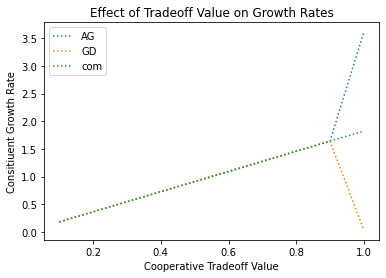

<Figure size 4000x4000 with 0 Axes>

In [ ]:
import matplotlib as mp
import matplotlib.pyplot as plt

save_output = True
fig,ax = plt.subplots()

plt.figure(figsize=(20,20), dpi=200)
ax.plot(trOff,comAG, label="AG",linestyle = ":")
ax.plot(trOff,comGD, label="GD",linestyle = ":")
ax.plot(trOff,comGR, label="com",linestyle = ":")


# ax.plot(tradeoffscan["fraction"],tradeoffscan["GD_uc"],label="GD uc",linestyle = ":")
# ax.plot(tradeoffscan["fraction"], [i.growth_rate for i in sols.solution.values],label="Com",linestyle = "-.")

ax.set_title("Effect of Tradeoff Value on Growth Rates")
ax.set_xlabel("Cooperative Tradeoff Value")
ax.set_ylabel("Consitiuent Growth Rate")
ax.legend()
if save_output:
        fig.savefig(f"C:/Users/domin/Masters-Thesis---Draft-1/images/Micom_Tests/tradeoffscan.pdf", bbox_inches = 'tight',pad_inches=0.2)
    

Another point of interest is the maximum yield available in community vs individually.
Is it meaningful to apply a maximum theoretical yield optimisation to a community? lets find out!

In [38]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\domin\\Submission\\project\\utils\\utils.py'>

In [39]:
# Modify the individual case testing code for a quick answer
from utils import set_bound_modifications, runcases, runcases_community

AG_tgt  = "HPAA_ADH"
GD_tgt  = "SALIDROSIDE_BIOSYNTHESIS"

com_TYR_tgt = "HPAA_ADH__AG_uc"
com_SAL_tgt = "SALIDROSIDE_BIOSYNTHESIS__GD_uc"

# AG_gr = [] # Growth Rate
# GD_gr = [] # Growth Rate

AG_tmy = [] # Theoretical Max Yield
GD_tmy = [] # Theoretical Max Yield

com_tmy_tyrosol = []
com_tmy_salidroside = []

# Cases consist of simple csv files of the rxn bounds to modify: rxn,lb,ub
_, com_tmy_tyrosol = runcases_community(com, "../../data/com_cases", com_TYR_tgt,1)
_, com_tmy_salidroside = runcases_community(com, "../../data/com_cases", com_SAL_tgt,1)

print("Community Theoretical Maximum Yield of TYROSOL: ", round(com_tmy_tyrosol[0],2))
print("Community Theoretical Maximum Yield of SALIDROSIDE: ", round(com_tmy_salidroside[0],2))

with AG as m:
    m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.lower_bound = m.slim_optimize() * 0.8
    print(m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.bounds)
    m.objective = m.reactions.EX_ac_e
    # m.objective = AG_tgt
    temp = m.optimize()
    print("AG TMY: ", temp.objective_value)
    AG_tmy = round(temp.objective_value,2)


with GD as m:
    m.reactions.EX_Tyrosol_e.lower_bound = -20
    m.objective = GD_tgt
    temp = m.optimize()
    print("GD TMY: ", temp.objective_value)
    GD_tmy = round(temp.objective_value,2)

[12:06:08] WARNING  `optimize_all` is deprecated and will be removed soon :(                       ]8;id=836202;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=288729;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#485\485]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=534119;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=626204;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

[12:06:09] WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=431459;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=790110;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

[12:06:10] WARNING  `optimize_all` is deprecated and will be removed soon :(                       ]8;id=588831;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=170556;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#485\485]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=430280;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=46833;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

[12:06:11] WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=364763;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=332382;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

[12:06:14] WARNING  `optimize_all` is deprecated and will be removed soon :(                       ]8;id=676284;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=121121;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#485\485]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=36017;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=179865;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=433554;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=367596;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

[12:06:15] WARNING  `optimize_all` is deprecated and will be removed soon :(                       ]8;id=364200;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=909237;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#485\485]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=94828;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=780518;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

[12:06:16] WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=210600;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=612704;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

Community Theoretical Maximum Yield of TYROSOL:  nan
Community Theoretical Maximum Yield of SALIDROSIDE:  nan
(0.6545793256855457, 1000.0)
AG TMY:  5.749230769230861
GD TMY:  8.935769230769221


The computed theoretical maximum yield for the community model is signifigantly larger for both Tyrosol and Salidroside. Let's visualise some of the internal exchange fluxes in these scenarios. 

In [197]:
# AG TMY internal exchange fluxes

# Visualise Internal Exchange Fluxes for MTY scenarios
pfba_solution = []
with com as m:
    m.objective = com_TYR_tgt
    # sol1 = m.slim_optimize()
    pfba_solution.append(cobra.flux_analysis.pfba(m))
    m.objective = com_SAL_tgt
    pfba_solution.append(cobra.flux_analysis.pfba(m))
    # sol1 = m.summary()
    
print(pfba_solution[0].fluxes["HPAA_ADH__AG_uc"])
print(pfba_solution[1].fluxes["EX_Salidroside_m"])

# com.reactions.EX_Salidroside_m
# utils.getInternalExchangeFluxes(com, pfba_solution[0])

21.208888888888914
6.499498207885324


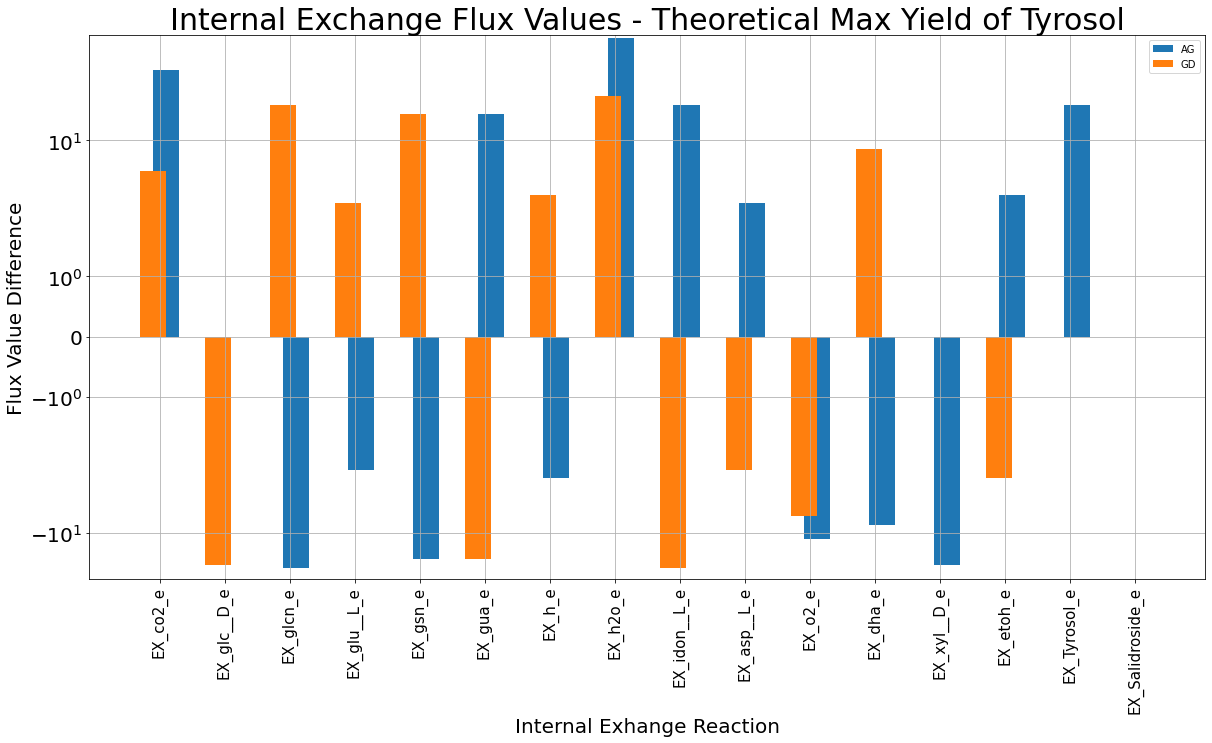

In [206]:

sol = pfba_solution[0]

def getInternalExchangeFluxes2(com, sol):
    '''
    Another version of this function to account for the format returned by 
    cobra.flux_analysis_pfba

    The reactions are not grouped into a dataframe by metabolite which means 
    it need to be processed before we can use the graphig function.
    '''
    import pandas as pd
    int_ex = [i.id for i in com.internal_exchanges]
    int_ex = [i[:-7] for i in int_ex]
    int_ex

    # for i in sol.fluxes.index:
    #     isinternalExchangeReaction = i[:-7] in int_ex
    #     if isinternalExchangeReaction:
    #         print(i, sol.fluxes[i])

    # for each intEx flux, find the corresponding fluxes in  sols.fluxes, one will have an "__AG_uc" suffix etc

    flux_container = []
    for rxn in int_ex:
        foo = []
        toadd_ag = 0
        toadd_gd = 0
        # print("Testing: ", rxn)
        c = 0
        for flucs in sol.fluxes.index:
            if c != 2:
                if flucs[:-7] == rxn:

                    foo.append(flucs) # debug

                    if flucs[-5:] == "AG_uc":
                        toadd_ag = sol.fluxes[flucs]
                        # print(toadd_ag)
                        c +=1

                    elif flucs[-5:] == "GD_uc":
                        toadd_gd = sol.fluxes[flucs]
                        # print(toadd_gd)
                        c +=1

            if c == 2:
                if toadd_ag != 0 or toadd_gd != 0:
                    tab = {
                        "rxn_id": rxn,
                        "AG_uc": round(toadd_ag,2),
                        "GD_uc": round(toadd_gd,2),
                        "medium": 0
                    }
                    # print("appending ", tab)
                    flux_container.append(tab)
                break
            elif c == 1 and "Salidro" in rxn:
                    tab = {
                        "rxn_id": rxn,
                        "AG_uc": 0,
                        "GD_uc": round(toadd_gd,2),
                        "medium": 0
                    }
                    # print("appending ", tab)
                    flux_container.append(tab)

        
    x = pd.DataFrame(flux_container)
    x.set_index("rxn_id",inplace=True)
    return x.drop_duplicates()


temp = getInternalExchangeFluxes2(com, sol)
temp
plotIntExchFlux(com, temp, _title = "Internal Exchange Flux Values - Theoretical Max Yield of Tyrosol",save_output=True)
   

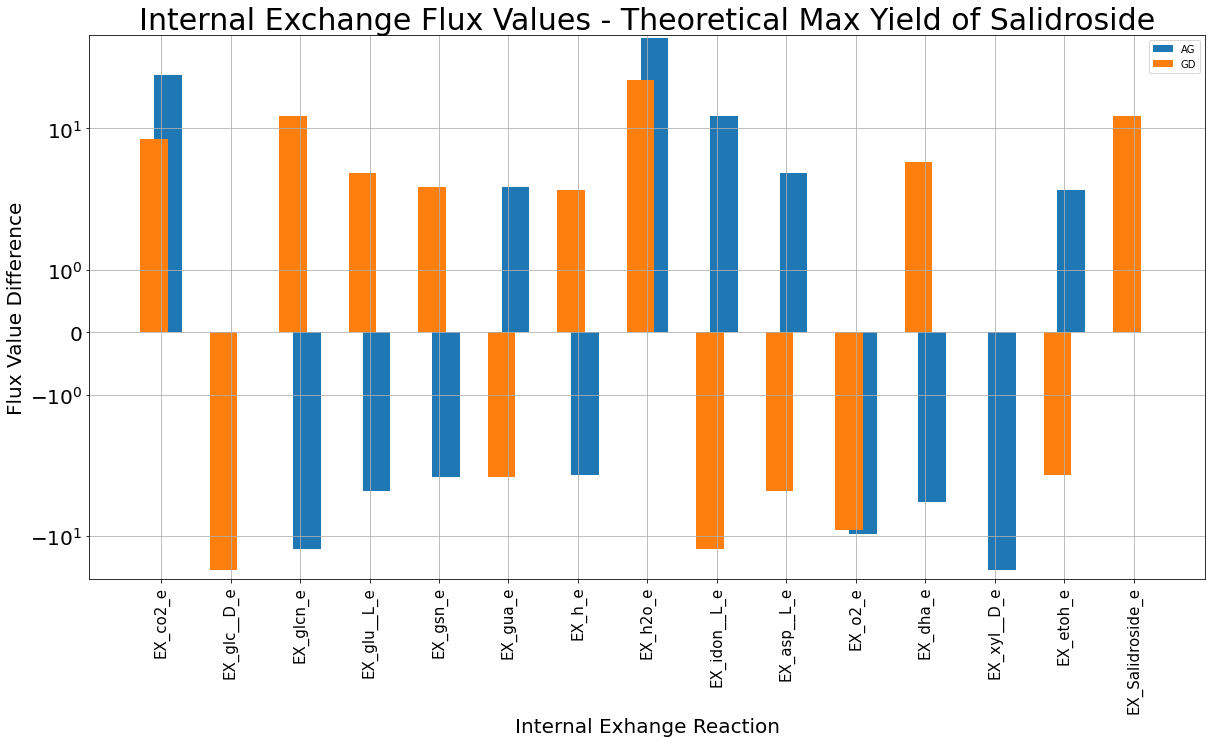

In [207]:
temp = getInternalExchangeFluxes2(com, pfba_solution[1])
temp
plotIntExchFlux(com, temp, _title = "Internal Exchange Flux Values - Theoretical Max Yield of Salidroside", save_output=True)

The next point of enquiry would be to ask what changes between the community and individual models with respect to exchange fluxes.

For the individual model the exchange fluxes are determined directly by the medium representation.
For community models the metabolites 'availible' to them depend on the metabolites excreted by the other strain...